# Random forest classifier for NMD prediction

In [27]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint, uniform
import shap
from xgboost import XGBClassifier
#logreg
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz



import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
negative_df = pd.read_csv('negative_set_down_and_insign.csv', index_col = 0)
positive_df = pd.read_csv('long_read_sleuth_dKD_up_filtered_features.csv', index_col = 0)

In [3]:
#Label
negative_df['NMD_sensitivity'] = 0
positive_df['NMD_sensitivity'] = 1

In [4]:
negative_df.describe()

,start_ORF,end_ORF,exon_with_stop_length,last_exon_length,t_length,distance_stop_EJC,50_nt,stop_TGA,stop_TAA,3_UTR_length,...,4th_stop_G,4th_stop_T,GC_perc_30_bp_round_stop,GC_perc_up_15_bp_stop,GC_perc_down_15_bp_stop,nr_exons_in_transcript,nr_exons_in_3prime,UPF1_motifs_in3prime_total,UPF1_motifs_in3prime_relative,NMD_sensitivity
count,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,...,3274.000000,3274.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.0
mean,258.937843,1255.502742,1074.448507,1260.667276,2632.665448,116.495430,0.322364,0.532297,0.257465,1377.162706,...,0.304826,0.186011,0.478428,0.508755,0.448101,9.274528,2.656612,5.542048,0.004346,0.0
std,343.481490,1250.825830,1515.871895,1603.216657,2229.748535,850.397276,0.467453,0.499032,0.437304,1697.456839,...,0.460404,0.389175,0.131035,0.152329,0.155042,7.421265,3.693037,7.463835,0.004252,0.0
min,0.000000,62.000000,22.000000,8.000000,191.000000,-6874.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.100000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0
25%,81.000000,442.000000,188.250000,279.000000,984.000000,-156.750000,0.000000,0.000000,0.000000,324.000000,...,0.000000,0.000000,0.366667,0.400000,0.333333,4.000000,1.000000,1.000000,0.001591,0.0
50%,173.000000,855.500000,491.000000,669.000000,1996.500000,-61.000000,0.000000,1.000000,0.000000,771.000000,...,0.000000,0.000000,0.466667,0.533333,0.466667,7.000000,1.000000,3.000000,0.003586,0.0
75%,321.000000,1676.750000,1344.500000,1639.750000,3516.750000,207.750000,1.000000,1.000000,1.000000,1793.500000,...,1.000000,0.000000,0.566667,0.600000,0.533333,12.000000,3.000000,7.000000,0.006167,0.0
max,5424.000000,15984.000000,19780.000000,19780.000000,21679.000000,9578.000000,1.000000,1.000000,1.000000,19698.000000,...,1.000000,1.000000,0.866667,1.000000,0.866667,78.000000,41.000000,110.000000,0.071429,0.0


In [5]:
positive_df.describe()

,start_ORF,end_ORF,exon_with_stop_length,last_exon_length,t_length,distance_stop_EJC,50_nt,stop_TGA,stop_TAA,3_UTR_length,...,4th_stop_G,4th_stop_T,GC_perc_30_bp_round_stop,GC_perc_up_15_bp_stop,GC_perc_down_15_bp_stop,nr_exons_in_transcript,nr_exons_in_3prime,UPF1_motifs_in3prime_total,UPF1_motifs_in3prime_relative,NMD_sensitivity
count,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,...,3268.000000,3268.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.0
mean,213.706277,994.913772,444.546923,911.954601,2432.723339,525.854966,0.706886,0.564595,0.239793,1437.809567,...,0.266524,0.199510,0.473146,0.503047,0.443246,11.327544,5.370201,5.510055,0.004196,1.0
std,265.569371,1180.577516,931.297514,1380.634305,2102.036620,894.676115,0.455260,0.495886,0.427022,1660.265204,...,0.442209,0.399693,0.117005,0.145617,0.137770,8.649829,5.729640,6.693357,0.004026,0.0
min,0.000000,62.000000,22.000000,3.000000,265.000000,-6216.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.066667,0.066667,0.000000,1.000000,1.000000,0.000000,0.000000,1.0
25%,65.000000,358.250000,109.000000,163.000000,891.000000,-5.000000,0.000000,0.000000,0.000000,368.000000,...,0.000000,0.000000,0.400000,0.400000,0.333333,5.000000,1.000000,1.000000,0.001791,1.0
50%,143.000000,611.000000,163.000000,424.000000,1849.500000,290.500000,1.000000,1.000000,0.000000,881.500000,...,0.000000,0.000000,0.466667,0.533333,0.466667,9.000000,4.000000,3.000000,0.003488,1.0
75%,275.000000,1213.250000,344.000000,1143.000000,3199.750000,772.000000,1.000000,1.000000,0.000000,2005.250000,...,1.000000,0.000000,0.566667,0.600000,0.533333,15.000000,7.000000,8.000000,0.005778,1.0
max,5731.000000,15239.000000,23264.000000,23264.000000,25280.000000,10035.000000,1.000000,1.000000,1.000000,21633.000000,...,1.000000,1.000000,0.866667,0.933333,0.866667,105.000000,62.000000,64.000000,0.066667,1.0


# preprocessing

In [6]:
NMD_features_df =pd.concat([negative_df, positive_df], axis=0, join='outer')
NMD_features_df.columns

Index(['name_tar', 'start_ORF', 'end_ORF', 'exon_with_stop_length',
       'last_exon_length', 't_length', 'distance_stop_EJC', 'ORF_id', '50_nt',
       'stop_TGA', 'stop_TAA', '3_UTR_length', '5_UTR_length',
       'distance_stop_from_start', 'stop_150bp_from_start', '4th_stop_C',
       '4th_stop_G', '4th_stop_T', 'GC_perc_30_bp_round_stop',
       'GC_perc_up_15_bp_stop', 'GC_perc_down_15_bp_stop',
       'nr_exons_in_transcript', 'nr_exons_in_3prime',
       'UPF1_motifs_in3prime_total', 'UPF1_motifs_in3prime_relative',
       'NMD_sensitivity'],
      dtype='object')

In [7]:
NMD_features_df.dropna(inplace=True)
X = NMD_features_df.drop(['name_tar',  'GC_perc_30_bp_round_stop', 
                           'ORF_id', 'NMD_sensitivity', 'UPF1_motifs_in3prime_relative'], axis=1)
y = NMD_features_df['NMD_sensitivity']

X['start_ORF'] = X['start_ORF']/X['t_length']
X['end_ORF'] = X['end_ORF']/X['t_length']

#normlaize X
for variable in ['exon_with_stop_length',
       'last_exon_length', 't_length', 'distance_stop_EJC',
       '3_UTR_length', '5_UTR_length',
       'distance_stop_from_start', 
        'GC_perc_up_15_bp_stop', 'GC_perc_down_15_bp_stop',
       'nr_exons_in_transcript', 'nr_exons_in_3prime',
       'UPF1_motifs_in3prime_total' ]:
    X[variable]=(X[variable]-X[variable].mean())/X[variable].std()

# Split the data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# EDA

<Axes: xlabel='distance_stop_EJC', ylabel='Count'>

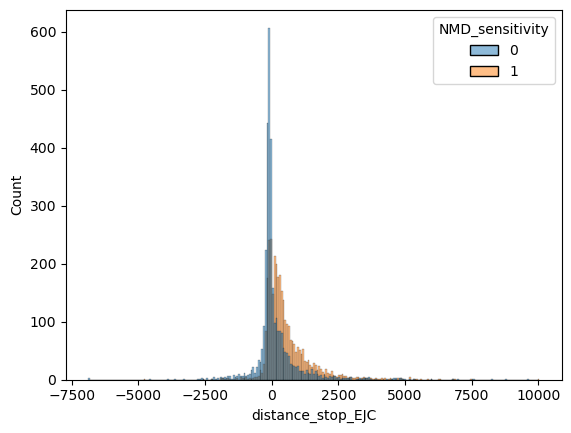

In [17]:
sns.histplot(NMD_features_df, x = 'distance_stop_EJC', hue = 'NMD_sensitivity')

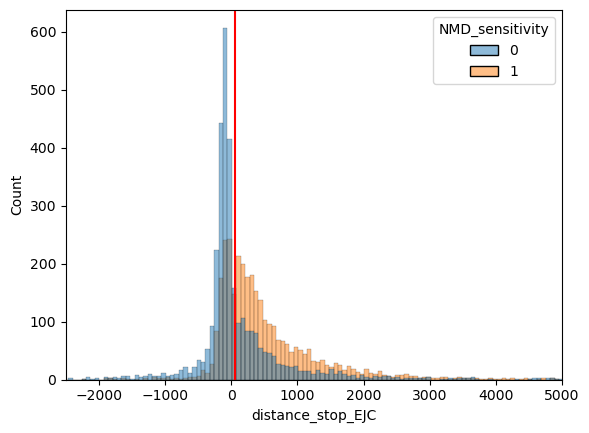

In [26]:
# depict visualization
fig, ax = plt.subplots()
ax = sns.histplot(NMD_features_df, x = 'distance_stop_EJC', hue = 'NMD_sensitivity', ax=ax)
ax.axvline(x = 50,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 650, 
           color = 'red') # Top of the plot
ax.set_xlim(-2500, 5000)
plt.show()

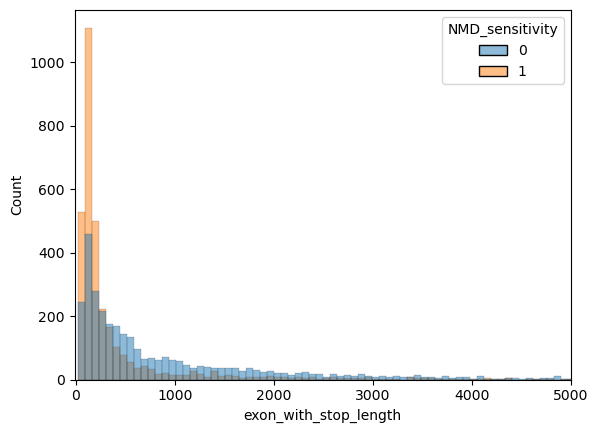

In [21]:
# depict visualization
fig, ax = plt.subplots()
sns.histplot(NMD_features_df, x = 'exon_with_stop_length', hue = 'NMD_sensitivity', ax=ax)
ax.set_xlim(-10, 5000)
plt.show()

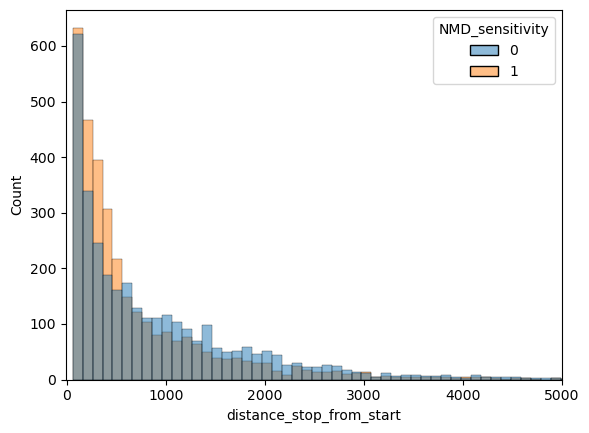

In [22]:
# depict visualization
fig, ax = plt.subplots()
sns.histplot(NMD_features_df, x = 'distance_stop_from_start', hue = 'NMD_sensitivity', ax=ax)
ax.set_xlim(-10, 5000)
plt.show()

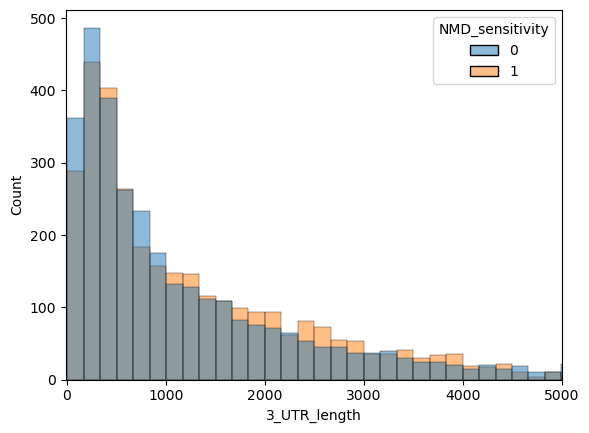

In [23]:
# depict visualization
fig, ax = plt.subplots()
sns.histplot(NMD_features_df, x = '3_UTR_length', hue = 'NMD_sensitivity', ax=ax)
ax.set_xlim(-10, 5000)
plt.show()

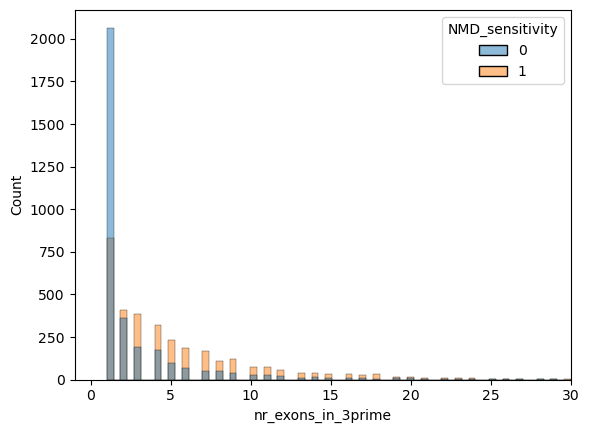

In [32]:
fig, ax = plt.subplots()
sns.histplot(NMD_features_df, x = 'nr_exons_in_3prime', hue = 'NMD_sensitivity', ax=ax)
ax.set_xlim(-1, 30)
plt.show()


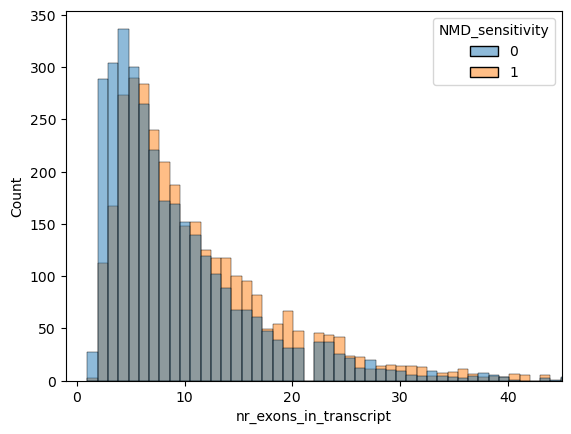

In [34]:
fig, ax = plt.subplots()
sns.histplot(NMD_features_df, x = 'nr_exons_in_transcript', hue = 'NMD_sensitivity', ax=ax)
ax.set_xlim(-1,45)
plt.show()


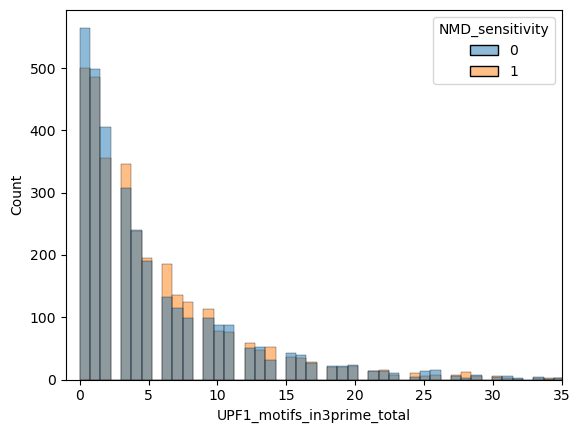

In [36]:
fig, ax = plt.subplots()
sns.histplot(NMD_features_df, x = 'UPF1_motifs_in3prime_total', hue = 'NMD_sensitivity', ax=ax)
ax.set_xlim(-1,35)
plt.show()

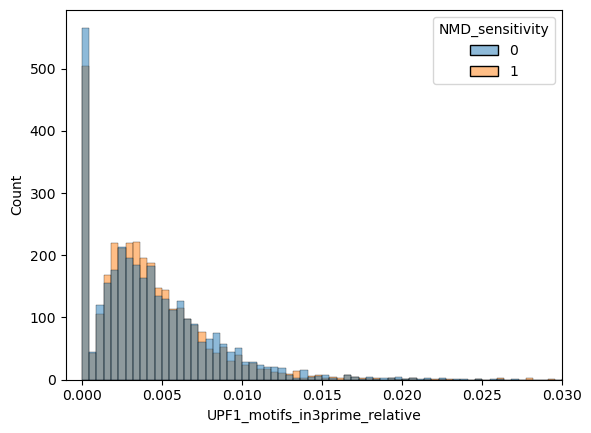

In [40]:
fig, ax = plt.subplots()
sns.histplot(NMD_features_df, x = 'UPF1_motifs_in3prime_relative', hue = 'NMD_sensitivity')
ax.set_xlim(-0.001, 0.03)
plt.show()

## Set baseline

In [8]:
kf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
correct_rates = []
errors = []
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    correct_rate = (sum(np.logical_and(X.iloc[test_index, 6] == 1.0, y[test_index].values == 1)) +\
    sum(np.logical_and(X.iloc[test_index, 6] == 0.0, y[test_index].values == 0))) /\
    len(X.iloc[test_index, 6].index)
    correct_rates.append(correct_rate)
    error = mean_squared_error(X.iloc[test_index, 6], y[test_index], squared=False)
    errors.append(error)
print(sum(correct_rates)/len(correct_rates))
print(sum(errors)/len(errors))

0.6933664822466559
0.5532261870720421


/var/folders/rx/4ms1h02572711qkwyq86_zhm0000gp/T/ipykernel_2048/1056361543.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correct_rate = (sum(np.logical_and(X.iloc[test_index, 6] == 1.0, y[test_index].values == 1)) +\
/var/folders/rx/4ms1h02572711qkwyq86_zhm0000gp/T/ipykernel_2048/1056361543.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum(np.logical_and(X.iloc[test_index, 6] == 0.0, y[test_index].values == 0))) /\
/var/folders/rx/4ms1h02572711qkwyq86_zhm0000gp/T/ipykernel_2048/1056361543.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys w

In [29]:
#Not sure how to do the confusion matrix without a leftout test set
# Create the confusion matrix
#cm = confusion_matrix(y_test, y_pred_50)

#ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# Train the random forest

In [30]:
rf = RandomForestClassifier(random_state= 0)
#cv = StratifiedKFold(10, random_state=0)
scores = cross_val_score(rf, X, y, groups = y, cv = 10)
errors = cross_val_score(rf, X, y, groups = y, cv = 10, scoring='neg_root_mean_squared_error')

In [31]:
print(scores.mean())
print(errors.mean())

0.6810129094007517
-0.5617803128674059


In [32]:
rf.fit(X, y)

RandomForestClassifier(random_state=0)

In [33]:
feature_scores = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

feature_scores

distance_stop_EJC             0.110180
exon_with_stop_length         0.106421
distance_stop_from_start      0.076053
last_exon_length              0.068529
end_ORF                       0.067781
start_ORF                     0.066310
t_length                      0.065089
3_UTR_length                  0.064290
5_UTR_length                  0.063077
nr_exons_in_transcript        0.049362
nr_exons_in_3prime            0.048146
50_nt                         0.046630
GC_perc_up_15_bp_stop         0.039730
UPF1_motifs_in3prime_total    0.038492
GC_perc_down_15_bp_stop       0.037661
stop_TGA                      0.009877
4th_stop_G                    0.008951
stop_150bp_from_start         0.008638
4th_stop_C                    0.008354
4th_stop_T                    0.008268
stop_TAA                      0.008159
dtype: float64

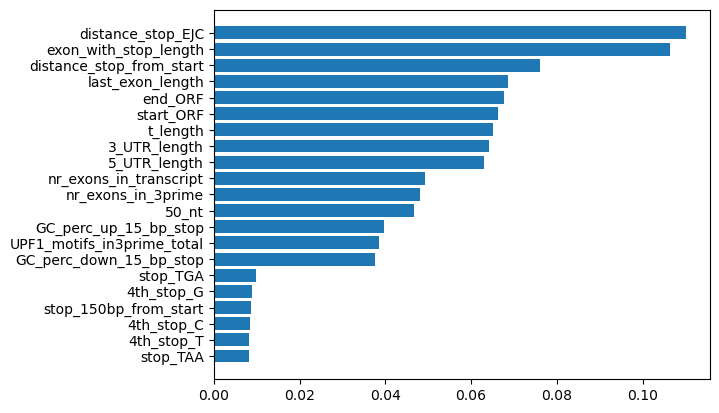

In [34]:
f_i = list(zip(tuple(X.columns),rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

# Feature selection

In [35]:
from sklearn.feature_selection import RFECV


#reverse selection
rfe = RFECV(rf,cv=5,scoring="accuracy")
rfe.fit(X,y)
selected_features = np.array(X.columns)[rfe.get_support()]
selected_features

array(['start_ORF', 'end_ORF', 'exon_with_stop_length',
       'last_exon_length', 't_length', 'distance_stop_EJC', '50_nt',
       'stop_TGA', '3_UTR_length', '5_UTR_length',
       'distance_stop_from_start', 'GC_perc_up_15_bp_stop',
       'GC_perc_down_15_bp_stop', 'nr_exons_in_transcript',
       'nr_exons_in_3prime', 'UPF1_motifs_in3prime_total'], dtype=object)

In [36]:
selected_features

array(['start_ORF', 'end_ORF', 'exon_with_stop_length',
       'last_exon_length', 't_length', 'distance_stop_EJC', '50_nt',
       'stop_TGA', '3_UTR_length', '5_UTR_length',
       'distance_stop_from_start', 'GC_perc_up_15_bp_stop',
       'GC_perc_down_15_bp_stop', 'nr_exons_in_transcript',
       'nr_exons_in_3prime', 'UPF1_motifs_in3prime_total'], dtype=object)

In [9]:
selected_features = ['start_ORF', 'end_ORF', 'exon_with_stop_length',
       'last_exon_length', 't_length', 'distance_stop_EJC', '50_nt',
       'stop_TGA', '3_UTR_length', '5_UTR_length',
       'distance_stop_from_start', 'GC_perc_up_15_bp_stop',
       'GC_perc_down_15_bp_stop', 'nr_exons_in_transcript',
       'nr_exons_in_3prime', 'UPF1_motifs_in3prime_total']
#evaluation
X = X.loc[:, selected_features]

In [37]:
selected_features = ['start_ORF', 'end_ORF', 'exon_with_stop_length',
       'last_exon_length', 't_length', 'distance_stop_EJC', '50_nt',
       'stop_TGA', '3_UTR_length', '5_UTR_length',
       'distance_stop_from_start', 'GC_perc_up_15_bp_stop',
       'GC_perc_down_15_bp_stop', 'nr_exons_in_transcript',
       'nr_exons_in_3prime', 'UPF1_motifs_in3prime_total']
#evaluation
X = X.loc[:, selected_features]
rf.fit(X,y)

scores = cross_val_score(rf, X, y, groups = y, cv = 10)
errors = cross_val_score(rf, X, y, groups = y, cv = 10, scoring='neg_root_mean_squared_error')

print(scores.mean())
print(errors.mean())

0.6848367065854285
-0.5580865560273424


# Hyperparameter tuning

In [47]:
param_dist = {'n_estimators': randint(200,500),
              'max_depth': randint(5,20), 
              'min_samples_split': randint(5,20),
              'max_features': ['sqrt', 'log2']}

# Create a random forest classifier
rf = RandomForestClassifier(random_state=50)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=20, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X, y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=50),
                   n_iter=20,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17cab23a0>,
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17c9344c0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17c934f40>})

In [48]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 11, 'max_features': 'log2', 'min_samples_split': 14, 'n_estimators': 485}


In [49]:
scores = cross_val_score(best_rf, X, y, groups = y, cv = 10)
errors = cross_val_score(best_rf, X, y, groups = y, cv = 10, scoring='neg_root_mean_squared_error')

print(scores.mean())
print(errors.mean())

0.6959964516656162
-0.547492373182664


In [54]:
from sklearn.model_selection import GridSearchCV
param_dist = {'n_estimators': range(450,510, 20),
              'max_depth': range(9,13, 1), 
              'min_samples_split': range(11,15,1),
              'max_features': ['sqrt', 'log2']}

# Create a random forest classifier
rf = RandomForestClassifier(random_state=0)

# Use random search to find the best hyperparameters
grid_search = GridSearchCV(rf, 
                                 param_grid = param_dist, 
                                 cv=5)

# Fit the random search object to the data
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': range(9, 13),
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': range(11, 15),
                         'n_estimators': range(450, 510, 20)})

In [55]:
# Create a variable for the best model
best_rf = grid_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  grid_search.best_params_)

Best hyperparameters: {'max_depth': 9, 'max_features': 'sqrt', 'min_samples_split': 14, 'n_estimators': 490}


In [56]:
scores = cross_val_score(best_rf, X, y, groups = y, cv = 10)
errors = cross_val_score(best_rf, X, y, groups = y, cv = 10, scoring='neg_root_mean_squared_error')

print(scores.mean())
print(errors.mean())

0.6993589653803954
-0.5442929363940292


# Ensmembl learning

In [61]:
# Define the hyperparameter distributions
param_dist = {
    'max_depth': randint(2, 10),
    'learning_rate': uniform(0.01, 0.1),
    'subsample': uniform(0.3, 0.7),
    'n_estimators':randint(10, 300)
}

# Create the XGBoost model object
xgb_model = XGBClassifier(random_state = 0)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy')

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X, y)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)



Best set of hyperparameters:  {'learning_rate': 0.016174270800896808, 'max_depth': 4, 'n_estimators': 51, 'subsample': 0.8215480731728175}
Best score:  0.7021007235254403


In [62]:

params  = random_search.best_params_
xgb_model = XGBClassifier(**params, random_state = 0)
xgb_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.016174270800896808,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=51, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [63]:

#create a new logistic regression model
log_reg = LogisticRegression()
#fit the model to the training data
log_reg.fit(X, y)

LogisticRegression()

In [64]:
#predictions

#log reg
log_scores = cross_val_score(log_reg, X, y, groups = y, cv = 10)
log_errors = cross_val_score(log_reg, X, y, groups = y, cv = 10, scoring='neg_root_mean_squared_error')

print(log_scores.mean())
print(log_errors.mean())
#xgboost
#xgb_pred = xgb_model.predict(X_test)


xgb_scores = cross_val_score(xgb_model, X, y, groups = y, cv = 10)
xgb_errors = cross_val_score(xgb_model, X, y, groups = y, cv = 10, scoring='neg_root_mean_squared_error')


print(xgb_scores.mean())
print(xgb_errors.mean())
#random forest
#y_pred

#50nt rule
#y_pred_50

0.6935560380045289
-0.5483627873166486
0.705931787940332
-0.5381193232336026


In [68]:
from sklearn.ensemble import VotingClassifier
# Create a voting classifier combining the individual classifiers
ensemble_classifier = VotingClassifier(
    estimators=[('rf', best_rf), ('xgb', xgb_model)],
    voting='hard', 
    weights=[1,2]  # Use soft voting for probability-based combination
)

scores = cross_val_score(ensemble_classifier, X, y, cv=10, scoring='accuracy')
errors = cross_val_score(ensemble_classifier, X, y, groups = y, cv = 10, scoring='neg_root_mean_squared_error')

print(scores.mean())
print(errors.mean())

0.705931787940332
-0.5381193232336026


In [69]:
# Create the confusion matrix
#cm = confusion_matrix(y_test, ensembl_pred)

#ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [74]:
#xgb classifier is the best tune further
param_dist = {
    'max_depth': range(3, 7, 1),
    'learning_rate': np.linspace(0.01, 0.03, num = 6),
    'subsample': np.linspace(0.7, 1.0, num = 6),
    'n_estimators':range(35, 65, 5)
}


# Create the XGBoost model object
xgb_model = XGBClassifier(random_state = 0)

# Create the RandomizedSearchCV object
grid_search = GridSearchCV(xgb_model, 
                                 param_grid = param_dist, 
                                 cv=10,
                                 scoring= 'accuracy')

# Fit the RandomizedSearchCV object to the training data
grid_search.fit(X, y)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)



Best set of hyperparameters:  {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 45, 'subsample': 0.82}
Best score:  0.7071561967458038


In [12]:
#params  = grid_search.best_params_
params = {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 45, 'subsample': 0.82}
xgb_model = XGBClassifier(**params, random_state = 0)
xgb_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=45, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [15]:
xgb_scores = cross_val_score(xgb_model, X, y, groups = y, cv = 10)
xgb_errors = cross_val_score(xgb_model, X, y, groups = y, cv = 10, scoring='neg_root_mean_squared_error')


print(xgb_scores.mean())
print(xgb_errors.mean())

0.7071561967458038
-0.5367389077051299


# SHAP values

In [53]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X)

In [43]:
shap_values[0]

array([-3.9490759e-02, -9.6988473e-03,  3.0451772e-01, -1.0022428e-01,
       -4.8726123e-02, -6.3459104e-01, -1.3478220e-02,  4.4977162e-03,
       -4.2332984e-03, -3.1100807e-03,  4.1466467e-02,  1.9664956e-02,
        2.0026365e-04,  3.8220352e-03, -3.2635290e-02, -2.0946095e-02],
      dtype=float32)

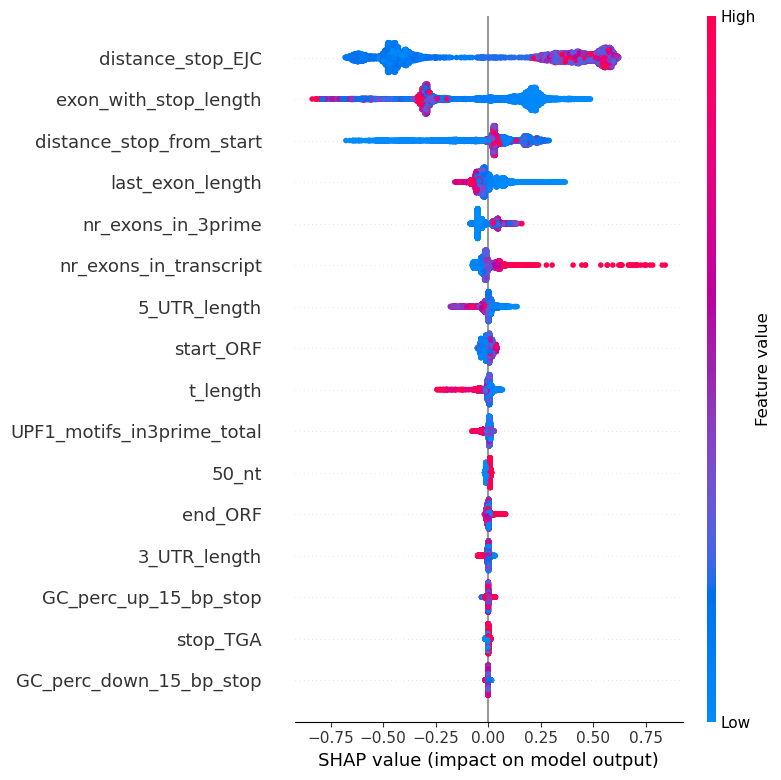

In [29]:
shap.summary_plot(shap_values, X)

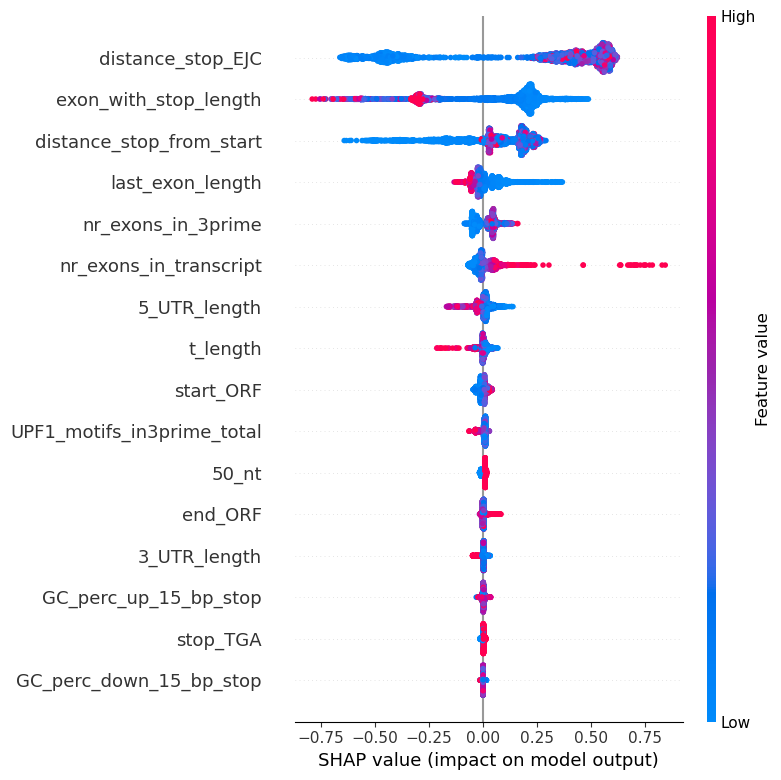

In [45]:
shap_values_positive = explainer.shap_values(X[y == 1.0])
shap.summary_plot(shap_values_positive, X[y == 1.0])

In [55]:
pred = xgb_model.predict(X, output_margin=True)

explainer = shap.TreeExplainer(xgb_model)
explanation = explainer(X)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

3.5762787e-07

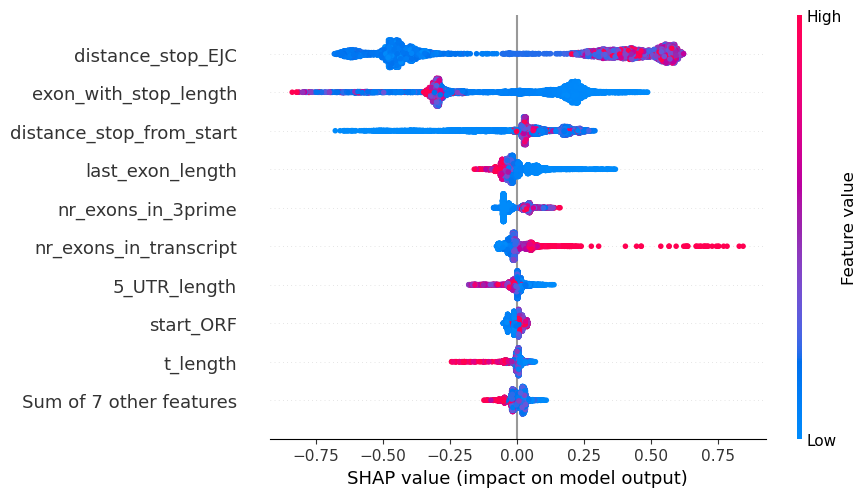

In [50]:
shap.plots.beeswarm(explanation)

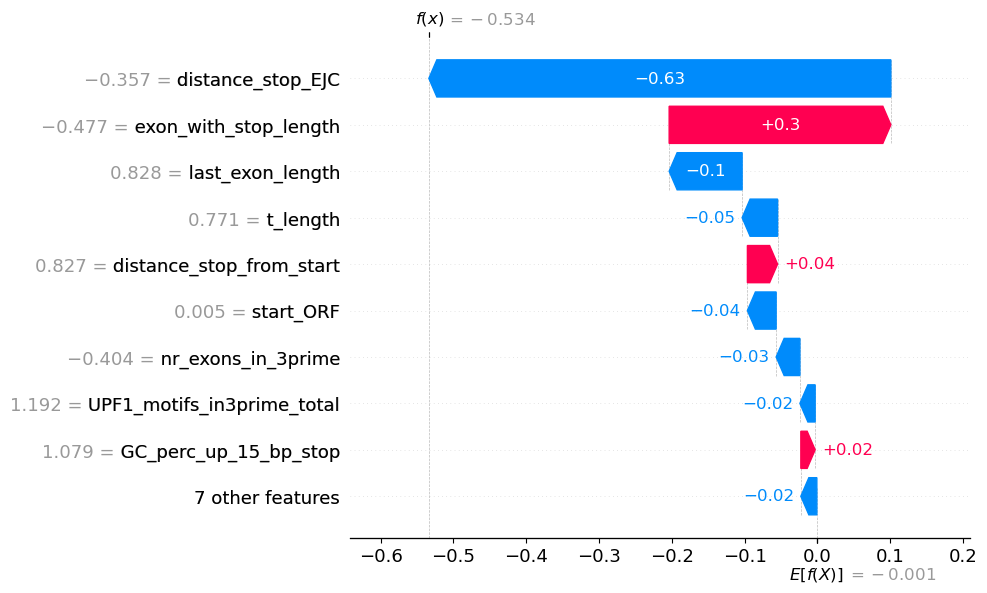

0


/var/folders/rx/4ms1h02572711qkwyq86_zhm0000gp/T/ipykernel_2048/3384577586.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(y[0])


In [58]:
shap.plots.waterfall(explanation[0])
print(y[0])

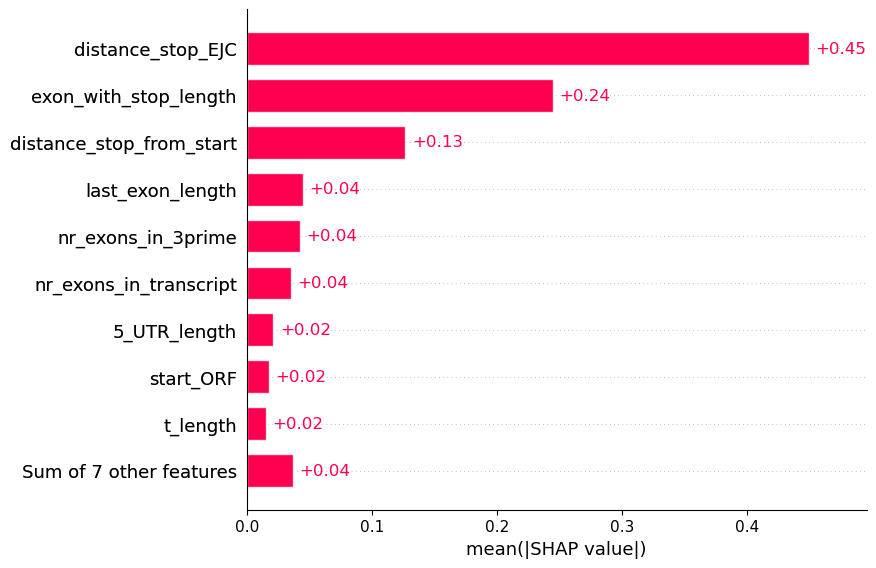

In [60]:
shap.plots.bar(explanation)